
# Ungraded Lab: Convolutional Autoencoders

In this lab, you will use convolution layers to build your autoencoder. This usually leads to better results than dense networks and you will see it in action with the Fashion MNIST dataset.

https://github.com/sasidhar-programmer/Tensorflow_Advance_Techniques/blob/main/4-Generative-deeplearning-with-tensorflow/week-2/C4_W2_Lab_4_FashionMNIST_CNNAutoEncoder.ipynb

In [9]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Conv2D, UpSampling2D
from tensorflow.keras.models import Model


# Prepare the Dataset

As before, you will load the train and test sets from TFDS. Notice that we don't flatten the image this time. That's because we will be using convolutional layers later that can deal with 2D images.


In [3]:

def map_image(image, label):
    '''Normalizes the image. Returns image as input and label.'''
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0

    return image, image

In [6]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('fashion_mnist', as_supervised=True, split="train")
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('fashion_mnist', as_supervised=True, split='test')
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

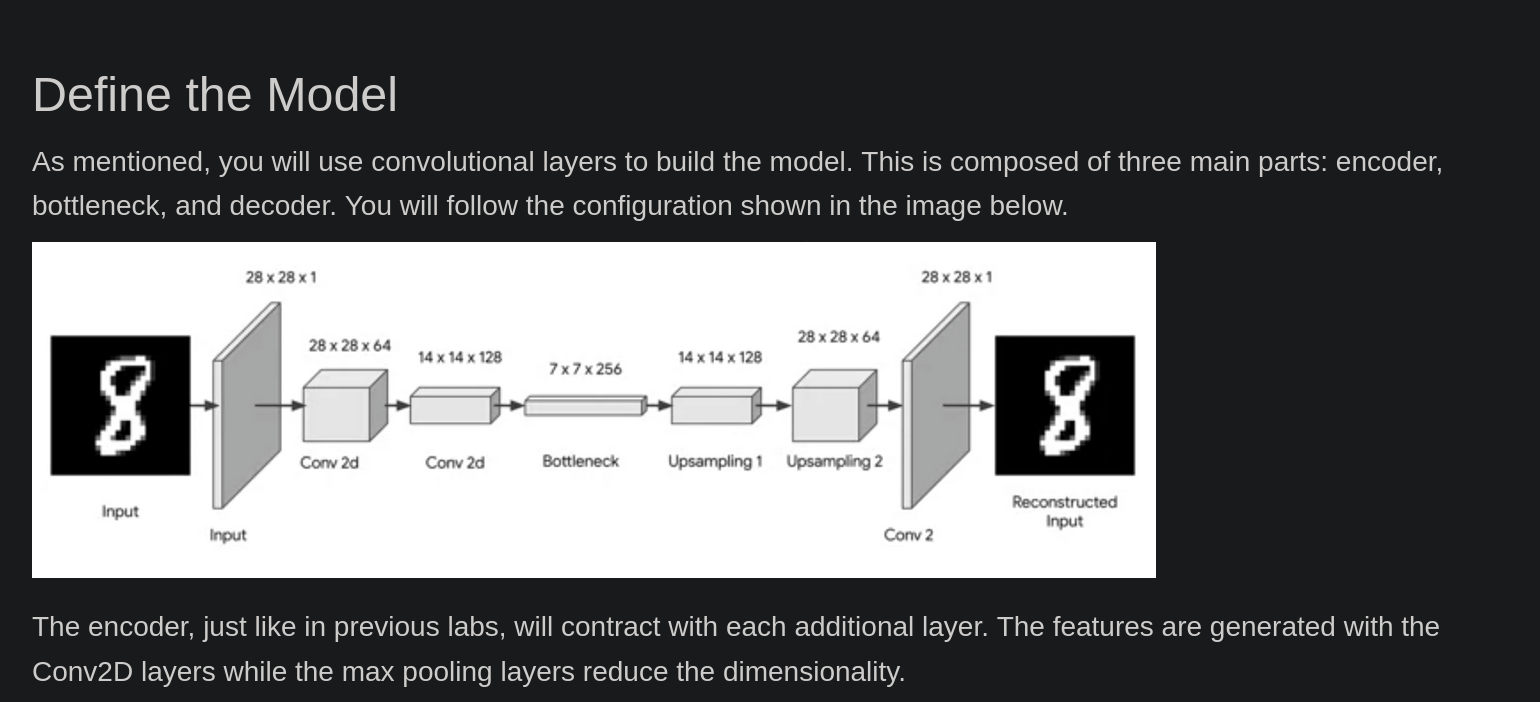

In [15]:
def encoder(inputs):
    '''defines the encoder with two conve2d and maxpooling layers'''
    conv1 = Conv2D(filters=64, kernel_size=(3,3),
                                   activation='relu', padding='same')(inputs)
    max_pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
    
    conv2 = Conv2D(filters=128, kernel_size=(3,3),
                            activation='relu', padding='same')(max_pool1)
    max_pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv2)
    
    return max_pool2



A bottleneck layer is used to get more features but without further reducing the dimension afterwards. Another layer is inserted here for visualizing the encoder output.


In [8]:

def bottle_neck(inputs):
    bottleneck = Conv2D(filters=256, kernel_size=(3,3), activation='relu',
                        padding="same")(inputs)
    
    # a non-essintial layer that we use to visualize. this doesn't go to the 
    #autoencoder - this layer doesn't impact the autoencoder
    encoder_visualization = Conv2D(filters=1, kernel_size=(3,3),
                                   activation='sigmoid', padding="same")(bottleneck)
    
    return bottleneck, encoder_visualization

In [11]:
def decoder(inputs):
    '''defines the decoder path to upsample back to the original image size'''
    k = (3,3)
    a = 'relu'
    a2 = 'sigmoid'
    p = 'same'
    u = (2,2)
    
    conv1 = Conv2D(filters=128, kernel_size=k, activation=a, padding=p)(inputs)
    upsample1 = UpSampling2D(size=u)(conv1)
    
    conv2 = Conv2D(filters=64, kernel_size=k, activation=a, padding=p)(upsample1)
    upsample2 = UpSampling2D(size=u)(conv2)
    
    # this will reconstruct the image giving us a 28x28x1 output
    conv3 = Conv2D(filters=1, kernel_size=k, activation=a2, padding=p)(upsample2)
    
    return conv3

In [12]:
def convolutional_auto_encoder():
    inputs = tf.keras.layers.Input(shape=(28,28,1))
    encoder_output = encoder(inputs)
    bottleneck_output, encoder_visualization = bottle_neck(encoder_output)
    decoder_output = decoder(bottleneck_output)
    
    model = Model(inputs=inputs, outputs = decoder_output)
    encoder_model = Model(inputs=inputs, outputs=encoder_visualization)
    return model, encoder_model

In [16]:
convolutional_model, convolutional_encoder_model = convolutional_auto_encoder()
convolutional_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        640       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 7, 128)         295040

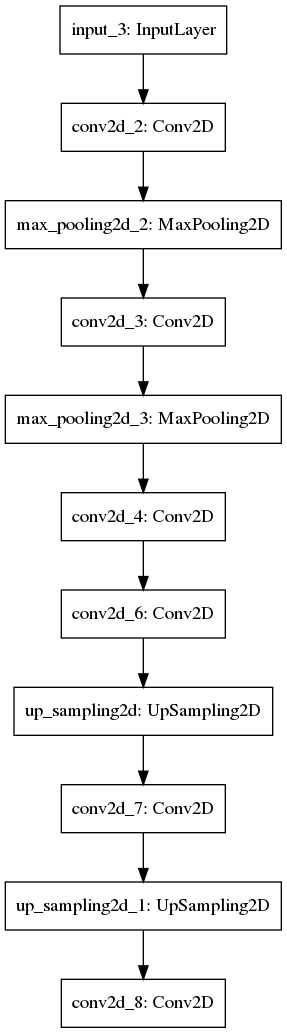

In [17]:
tf.keras.utils.plot_model(convolutional_model)

In [18]:
train_steps = 60000 // BATCH_SIZE
valid_steps = 60000 // BATCH_SIZE

convolutional_model.compile(optimizer=tf.keras.optimizers.Adam(),
                            loss='binary_crossentropy')

conv_model_history = convolutional_model.fit(train_dataset,
                                             steps_per_epoch=train_steps,
                                             validation_data=test_dataset,
                                             validation_steps=valid_steps,
                                             epochs=40)


Epoch 1/40
468/468 [==============================] - 14s 19ms/step - loss: 0.2875 - val_loss: 0.2669
Epoch 2/40
468/468 [==============================] - 9s 17ms/step - loss: 0.2613 - val_loss: 0.2599
Epoch 3/40
468/468 [==============================] - 8s 17ms/step - loss: 0.2560 - val_loss: 0.2565
Epoch 4/40
468/468 [==============================] - 8s 17ms/step - loss: 0.2531 - val_loss: 0.2540
Epoch 5/40
468/468 [==============================] - 8s 17ms/step - loss: 0.2514 - val_loss: 0.2527
Epoch 6/40
468/468 [==============================] - 8s 17ms/step - loss: 0.2503 - val_loss: 0.2517
Epoch 7/40
468/468 [==============================] - 8s 18ms/step - loss: 0.2495 - val_loss: 0.2511
Epoch 8/40
468/468 [==============================] - 8s 18ms/step - loss: 0.2489 - val_loss: 0.2505
Epoch 9/40
468/468 [==============================] - 8s 18ms/step - loss: 0.2484 - val_loss: 0.2501
Epoch 10/40
468/468 [==============================] - 8s 18ms/step - loss: 0.2479 - val_l

In [19]:


def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))



originall image -> latent vector (encodings) -> decoded


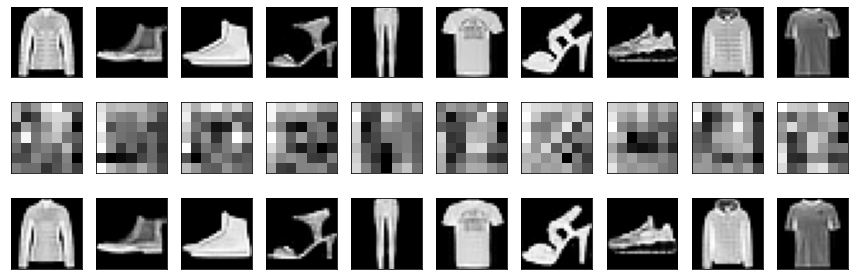

In [20]:


# take 1 batch of the dataset
test_dataset = test_dataset.take(1)

# take the input images and put them in a list
output_samples = []
for input_image, image in tfds.as_numpy(test_dataset):
      output_samples = input_image

# pick 10 indices
idxs = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# prepare test samples as a batch of 10 images
conv_output_samples = np.array(output_samples[idxs])
conv_output_samples = np.reshape(conv_output_samples, (10, 28, 28, 1))

# get the encoder ouput
encoded = convolutional_encoder_model.predict(conv_output_samples)

# get a prediction for some values in the dataset
predicted = convolutional_model.predict(conv_output_samples)

# display the samples, encodings and decoded values!
display_results(conv_output_samples, encoded, predicted, enc_shape=(7,7))

print('originall image -> latent vector (encodings) -> decoded')